In [1]:
import pandas as pd
import numpy as np
import random
import transformers
import tensorflow as tf
from transformers import BertTokenizer
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from bs4 import BeautifulSoup    

/opt/anaconda3/envs/sandbox_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-08 13:23:56.940908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create definitions to preprocess the text and model the relevant data

In [2]:
# Remove HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove stopwords, punctuation, and convert to lowercase
def preprocess_text(text):
    # Remove HTML tags
    text = remove_html_tags(text)
    
    # Replace hyphens between words with a space
    text = text.replace('-', ' ')
    
    # Tokenize text into words
    tokens = word_tokenize(text)
    
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word not in punctuation]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text
# Load the BERT tokenizer
max_length = 256
vocab_size = 30522
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_and_batch(train, train_labels, tokenizer, batch_size, shuffle_buffer_size,max_length):
    # Tokenize the train data
    input_ids = []
    attention_masks = []
    for text in train:
        train_tokens = tokenizer.encode_plus(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            #return_tensors='tf'
            )
        input_ids.append(train_tokens['input_ids'])
        attention_masks.append(train_tokens['attention_mask'])
    #print(np.array(input_ids[:5]))
    # Convert the tokens into tensors
    tensor = tf.data.Dataset.from_tensor_slices((input_ids,train_labels))
 
    # # Shuffle and Batch the tensors
    tensor = tensor.shuffle(shuffle_buffer_size)
    tensor = tensor.batch(batch_size)
    
    return tensor

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(max_length,), dtype='int32'))
        model.add(layers.Embedding(input_dim=vocab_size, 
                                   output_dim=hp.Int('embed_dim', min_value=4, max_value=128),
                                   mask_zero=True))
        #try flatten or move this to the end
        model.add(layers.GlobalAveragePooling1D())
        # Add 1 to 3 dense layers
        for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
            model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512),
                                    activation=hp.Choice('activation_' + str(i), values=['sigmoid', 'relu', 'tanh'])))
            
            # Add dropout layer between dense layers
            if hp.Boolean('dropout_' + str(i)):
                model.add(layers.Dropout(rate=0.2))
        
        # Add final dense layer with 1 node
        
        model.add(layers.Dense(units=1))
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        # Compile the model
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                      loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics= tf.metrics.BinaryAccuracy(threshold=0.0)
                      )
        return model

In [5]:
#######################User Input############################
round = 2
df = pd.read_excel('R2_review_for_retraining.xlsx')
#############################################################
df['clean_TA'] = df['title'].fillna('').apply(preprocess_text) + ' ' + df['Abstracts'].fillna('').apply(preprocess_text) 

## Generate an ensemble of 100 predictive models

In [9]:
# Apply preprocessing to the 'data_TA' column
data_TA = df.dropna(subset=['Relevant'])
#print(data_TA['Relevant'].isna().sum())
if data_TA.loc[data_TA['Relevant'] == 5].shape[0]<data_TA.loc[data_TA['Relevant'] == 1].shape[0]:
     sample_size = data_TA.loc[data_TA['Relevant'] == 5].shape[0]
     print('Less relevant docs')
else:
     sample_size = data_TA.loc[data_TA['Relevant'] == 1].shape[0] 
     print('Less nonrelevant docs')  

data_TA.loc[data_TA['Relevant']==1, 'Relevant'] = 0
data_TA.loc[data_TA['Relevant']==5, 'Relevant'] = 1

# Create a list of 10 random numbers from 1 through 100
random_numbers = [#15, 
                  32, 69, 75, 83, 8, 68, 99, 44, 92
                  ] #random.sample(range(1, 101), 10)

# Iterate through the list of random numbers and create a training and validation set for each

for num in random_numbers:
    # Select 33 rows where the 'relevant' column is 5
    relevant_1_rows = data_TA[data_TA['Relevant'] == 1].sample(n=sample_size, random_state=num)
    
    # Select 33 rows where the 'relevant' column is 1
    relevant_0_rows = data_TA[data_TA['Relevant'] == 0].sample(n=sample_size, random_state=num)
    balanced_data = pd.concat([relevant_0_rows, relevant_1_rows]).sample(frac=1,random_state=num).reset_index(drop=True)

    # Split off 10% for a validation set
    
    valnotrel = balanced_data.loc[balanced_data['Relevant'] == 0].sample(frac=0.2, random_state=num)
    valrel = balanced_data.loc[balanced_data['Relevant'] == 1].sample(frac=0.2, random_state=num)
    raw_val = pd.concat([valnotrel, valrel]).sample(frac=1,random_state=num)
    
    raw_train = balanced_data.drop(raw_val.index).reset_index(drop=True)

# Save the training and validation sets to CSV
    raw_train[['Relevant','clean_TA']].to_csv(f'data/R{round}_train_{num}.csv', index=False)
    raw_val[['Relevant','clean_TA']].to_csv(f'data/R{round}_val_{num}.csv', index=False)

# reload the data  
    #raw_train = pd.read_csv(f'train_{num}.csv')
    #raw_val = pd.read_csv(f'val_{num}.csv')

#tokenize the data

    train_data = tokenize_and_batch(raw_train['clean_TA'], 
                                    raw_train['Relevant'], 
                                    tokenizer, 
                                    batch_size=10, 
                                    shuffle_buffer_size=10000,
                                    max_length=256)
    #print(np.asarray(train_data))
    val_data = tokenize_and_batch(raw_val['clean_TA'], 
                                  raw_val['Relevant'], 
                                  tokenizer=tokenizer, 
                                  batch_size=10, 
                                  shuffle_buffer_size=10000,
                                  max_length=256)
#set up and train the model
    best_model = []
    hypermodel = MyHyperModel()

    tuner = RandomSearch(
        hypermodel,
        objective='val_binary_accuracy',
        max_trials=50,
        directory='Tuner_delete_me',
        project_name=f'R1_{num}'
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.75,
        patience=3,
        min_lr=1e-7
    )
    
    tuner.search(train_data,
                 epochs=50, 
                 validation_data=(val_data
                                  ),
                 batch_size=10,
                 callbacks=[early_stopping,reduce_lr]
                 )
    
    best_model = tuner.get_best_models(num_models=10)
    for i in range(len(best_model)):
         best_model[i].save(f'models/R{round}_model_{num}_{i}.keras')

Trial 50 Complete [00h 00m 53s]
val_binary_accuracy: 0.8214285969734192

Best val_binary_accuracy So Far: 0.9107142686843872
Total elapsed time: 00h 16m 04s


## Predict and sort the database

In [10]:
#predict df using all 100 models
random_numbers = [15, 32, 69, 
                  75, 83, 8, 68, 99, 44, 92
                  ]

predictions = []
input_ids = []
attention_masks = []
targets = df['Relevant'].values
for text in df['clean_TA']:
    train_tokens = tokenizer.encode_plus(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        #return_tensors='tf'
        )
    input_ids.append(train_tokens['input_ids'])
    attention_masks.append(train_tokens['attention_mask'])
features = np.array(input_ids)
print('All data tokenized using tokenizer', tokenizer)

for num in random_numbers:
    for i in range(10):
        model = keras.models.load_model(f'models/R{round}_model_{num}_{i}.keras')
        predict = model.predict(features,batch_size=10)
        predict = np.where(predict >= 0, 1, 0)
        predictions.append(predict)

sum_predictions = np.sum(predictions, axis=0)
#calculate uncertainty as 1 divided by the sum of 1 predictions mininus the sum of 0 predictions
#count of 0's in predictions
count_0 = np.count_nonzero(np.array(predictions) == 0, axis=0)

df[f'R{round} Uncertanty'] = 1 / (np.abs(sum_predictions - count_0)+10**(-6))
df[f'R{round} Prediction score'] = sum_predictions
df = df.sort_values(by=f'R{round} Prediction score', ascending=False)
df.to_excel(f'R{round}_predictions_for_review.xlsx', index=False)
df.head()


All data tokenized using tokenizer BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
394/394 [==============================] - 1s 2ms/step


,Master patent number,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,Abstracts,Relevant,Round,clean_TA,R1 Uncertanty,R1 Prediction score,R2 Uncertanty,R2 Prediction score
0,CN-113956744-A,Low-odor rust-coated single-component epoxy co...,"_ññ_Ø_ïà_ó_ÿ__µ_Ô_óØ_¦_¶_, _ïà_ó_...","__ë___, _óÑ­__, _ö__",10/26/21,10/26/21,1/21/22,NaN,https://patents.google.com/patent/CN113956744A/en,https://patentimages.storage.googleapis.com/6c...,The invention discloses a low-odor rust-coated...,5.0,1.0,low odor rust coated single component epoxy co...,0.010000,100,0.01,100
31,CN-112029382-B,Long-acting anticorrosion solvent-free univers...,____¥ª_×â__ÝóÝóÑ¦óØ_¦_¶_,"_¬ â_â_, ó__¦__, ___ â__, ó_ _Ï_",9/18/20,9/18/20,11/16/21,11/16/21,https://patents.google.com/patent/CN112029382B/en,NaN,\nThe invention relates to the technical field...,5.0,2.0,long acting anticorrosion solvent free univers...,0.010101,99,0.01,100
47,WO-2007102587-A1,High-solid anticorrosive coating composition,"Chugoku Marine Paints, Ltd.",Osamu Kato,3/9/06,3/8/07,9/13/07,NaN,https://patents.google.com/patent/WO2007102587...,NaN,\n[PROBLEMS] To provide a high-solid anticorro...,5.0,2.0,high solid anticorrosive coating composition p...,0.010101,99,0.01,100
48,JP-2018058917-A,"Aqueous surface conditioner composition, metho...","__Ïó¥ïóØ¶_µ¥óÑ¦óÒ¯_______, Dainippon Toryo C...","ó __¬×__ _óØ¶, Junjiro Yoshimoto, ó __¬×__...",9/30/16,9/30/16,4/12/18,NaN,https://patents.google.com/patent/JP2018058917...,NaN,\nPROBLEM TO BE SOLVED: To provide an aqueous ...,5.0,2.0,aqueous surface conditioner composition method...,0.010101,99,0.01,100
49,CN-116410642-A,Solvent-free anti-corrosion lining coating and...,__óæ ó____ _óÝóÑ¦_×Ñ_ ïÒà¸Ý_¦½óØ_¦_¶_...,"_Ïê_ªë, óÑ__ï_í, __Ò__ë__, _óóæ , ó...",12/31/21,12/31/21,7/11/23,NaN,https://patents.google.com/patent/CN116410642A/en,NaN,\nThe invention provides a solvent-free anti-c...,5.0,2.0,solvent free anti corrosion lining coating pre...,0.010101,99,0.01,100


## Plot the effect of retraining

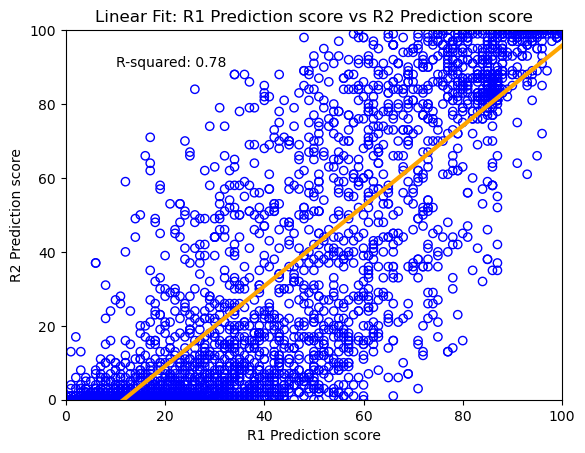

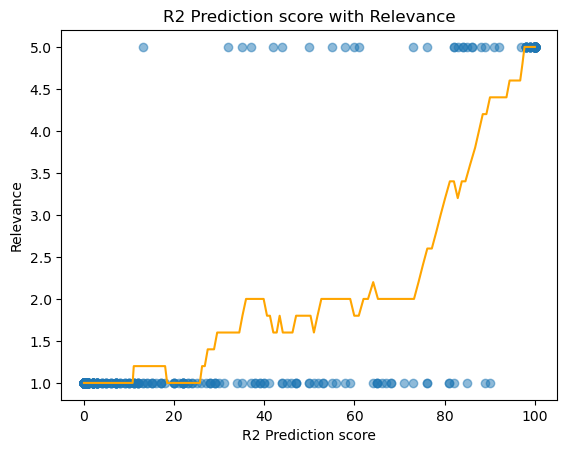

In [56]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['R1 Prediction score'], df['R2 Prediction score'])
line = slope * df['R1 Prediction score'] + intercept

plt.scatter(df['R1 Prediction score'], df['R2 Prediction score'], marker='o', edgecolor = 'blue', facecolor = 'none')
# Plot the linear fit for R1 Prediction score vs R2 Prediction score
plt.plot(df['R1 Prediction score'], line, color='orange', linewidth=3)

# Add labels and title for R1 Prediction score vs R2 Prediction score
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('R1 Prediction score')
plt.ylabel('R2 Prediction score')
plt.title('Linear Fit: R1 Prediction score vs R2 Prediction score')

# Add R-squared value to the plot for R1 Prediction score vs R2 Prediction score
r_squared = r_value**2
plt.text(0.1, 0.9, f'R-squared: {r_squared:.2f}', transform=plt.gca().transAxes)

# Show the plot for R1 Prediction score vs R2 Prediction score
plt.show()

# Plot R2 Prediction score with Relevance
# Filter the data where df['Relevant'] is not equal to 3
filtered_data = df[['R2 Prediction score','Relevant']]
filtered_data = filtered_data[filtered_data['Relevant'] != 3]
filtered_data = filtered_data.sort_values(by='R2 Prediction score', ascending=False)
filtered_data = filtered_data.dropna(subset=['Relevant'])

# Add labels and title for R2 Prediction score with Relevance
plt.xlabel('R2 Prediction score')
plt.ylabel('Relevance')
plt.title('R2 Prediction score with Relevance')

# Plot the filtered data for R2 Prediction score with Relevance
plt.scatter(filtered_data['R2 Prediction score'], filtered_data['Relevant'], alpha=0.5)

# Calculate the moving average with a period of 20
moving_average = filtered_data.rolling(window=20).mean()
moving_average = moving_average.dropna()
moving_average = moving_average.sort_values(by='R2 Prediction score', ascending=False)

# Plot the moving average line
plt.plot(moving_average['R2 Prediction score'],moving_average['Relevant'], color='orange')

# Add labels and title for R2 Prediction score with Relevance
plt.xlabel('R2 Prediction score')
plt.ylabel('Relevance')
plt.title('R2 Prediction score with Relevance')

# Show the plot for R2 Prediction score with Relevance
plt.show()
